# Preambule

In [1]:
library(tidyverse)
library(stringr)
library(ggplot2)
library(ggpubr)
library(viridis)
library(ggbeeswarm)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite



In [2]:
compatibleNames <- function(x){
    x <- x %>% str_replace_all(pattern = '[:punct:]', replacement = '_') %>% 
                    str_replace_all(pattern = ' ', replacement = '_') %>% 
                    str_replace_all(pattern = '\\_+', replacement = '_') %>%
                    str_replace_all(pattern = '\\_$', replacement = '')
    return(x)
}

In [3]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggbeeswarm_0.6.0  viridis_0.5.1     viridisLite_0.3.0 ggpubr_0.4.0     
 [5] forcats_0.5.0     stringr_1.4.0     dplyr_1.0.2       purrr_0.3.4      
 [9] readr_1.4.0       tidyr_1.1.2       tibble_3.0.4      ggplot2_3.3.2    
[13] tidyverse_1.3.0  

loaded via a nam

# identified

In [4]:
tax_names <- read.table('../data/taxonomy_table.txt', sep = '\t', header = TRUE)

## results from analyses

In [5]:
# from the main text and supplementary table 4:
# order ignored
# Strains: species used, if the species was not detected in data, then the genus is used
qinH <- c('g_Bacteroides', 'g_Alistipes', 'g_Clostridium', 'g_Dialister', 'g_Eggerthella', 'g_Eubacterium'
          , 'g_Oscillibacter', 'g_Parabacteroides', 'g_Subdoligranulum', 'f_Lachnospiraceae', 'f_Porphyromonadaceae'
          , 'f_Ruminococcaceae', 's_Alistipes_indistinctus', 's_Bacteroides_clarus', 's_Bacteroides_uniformis'
          , 's_Bilophila_wadsworthia', 's_Coprococcus_comes', 's_Faecalibacterium_prausnitzii')

qinC <- c('g_Veillonella', 'g_Streptococcus', 'g_Clostridium', 'g_Prevotella','g_Lactobacillus', 'g_Aggregatibacter'
          , 'g_Campylobacter', 'g_Haemophilus', 's_Bifidobacterium_dentium', 's_Clostridium_perfringens'
          , 's_Clostridium_symbiosum', 's_Fusobacterium_nucleatum', 's_Lactobacillus_fermentum'
          , 's_Lactobacillus_mucosae', 's_Lactobacillus_salivarius', 's_Megasphaera_micronuciformis'
          , 's_Prevotella_buccae', 's_Ruminococcus_gnavus', 's_Streptococcus_anginosus', 's_Streptococcus_oralis'
          , 's_Streptococcus_parasanguinis', 's_Streptococcus_salivarius', 's_Veillonella_parvula' )

In [6]:
endor_feat <- readRDS('../tmp/agg_imp.RDS')

In [7]:
qin <- c(qinH, qinC) %>% unique
endor <- as.character(endor_feat$Feature)

## merge

In [8]:
getFam <- function(feature, tax_names){
    res <- subset(tax_names, f == feature | g == feature | s == feature, select = f) %>% unique %>% unlist
    if(length(res) == 0) res <- NA
    return(res)
}

In [9]:
feats <- data.frame(Feature = c(as.character(endor_feat$Feature), qinH, qinC) %>% unique)
feats$Family <- sapply(feats$Feature, getFam, tax_names = tax_names)

In [10]:
feats$Family[feats$Feature == 's_Bacteroides_clarus'] <- 'f_Bacteroidaceae'
feats$Family[feats$Feature == 's_Ruminococcus_gnavus'] <- 'f_Lachnospiraceae'
feats$Family[feats$Feature == 's_Streptococcus_oralis'] <- 'f_Streptococcaceae'

In [11]:
feats$Found <- ifelse(feats$Feature %in% qin & feats$Feature %in% endor, 'Both'
                     , ifelse(feats$Feature %in% qin, 'Qin et al., 2014'
                             , ifelse(feats$Feature %in% endor, 'endoR', 'None')))

In [12]:
per_fam <- list()
for (fam in unique(feats$Family)){
    per_fam[[fam]] <- feats %>% subset(Family == fam)
}

# relative abundances

In [13]:
target <- readRDS('../data/X.RDS') %>% add_column(target = readRDS('../data/target.RDS'), `.before` = 1)
suppressMessages(X <- readRDS('../data/X_unfiltered.RDS') %>% left_join(target))

# plots

In [14]:
mini <- X[,sapply(X,is.numeric)] %>% unlist %>% unique
mini <- mini[mini > 0] %>% min
mini

[1] 2.999031e-07

## All plots

In [15]:
tmp <- feats$Feature[feats$Feature %in% colnames(X)]
check_m <- X %>% select(all_of(c('target', tmp))) %>% reshape2::melt(value.name = 'RA')
colnames(check_m)[2] <- 'Feature'

Using target as id variables



In [16]:
to_annnot <- feats$Feature[!(feats$Feature %in% colnames(X))]

In [17]:
check_m <- check_m %>% add_row(target = rep(c('Healthy', 'Cirrhosis'), length(to_annnot))
                                 , Feature = unlist(lapply(to_annnot, rep, times = 2))
                                 , RA = rep(NA, 2*length(to_annnot))) 
check_m <- check_m %>% left_join(feats, by = 'Feature')

In [18]:
check_m$RA_pseudo <- ifelse(check_m$RA == 0, mini, check_m$RA)

In [19]:
tmp <- check_m %>% select(Family, Found, Feature) %>% unique %>% 
                        arrange(Family, Found, Feature) %>% select(Feature) %>% unlist
check_m$Feature <- factor(check_m$Feature, levels = tmp)
to_annnot <- which(tmp %in% to_annnot)

In [20]:
to_highlight <- which(tmp %in% c('s_Megasphaera_micronuciformis', 's_Veillonella_parvula', 'g_Streptococcus', 'g_Leptotrichia'
                                 , 'f_Pasteurellaceae', 'g_Haemophilus', 's_Rikenella_microfusus', 'g_Alistipes'))

In [21]:
n_fam <- feats %>% count(Family) %>% arrange(Family)
n_fam$n_cum <- cumsum(n_fam$n)

In [22]:
ra_plot <- ggplot(check_m, aes(x = factor(Feature, levels = tmp), y = RA, color = target))+

geom_tile(data = feats, aes(fill = Found, y = 0.5), color = NA, alpha = 0.2)+
geom_boxplot(outlier.size = .5)+

geom_vline(xintercept = n_fam$n_cum +0.5,  color = 'gray40')+
annotate(geom = 'text', label = '*', x = to_annnot, y = 0.1, size = 8)+
annotate(geom = 'text', label =  sprintf('\u2193'), x = to_highlight, y = 0.9, size = 7)+

theme_classic()+
theme(legend.title = element_text(size = rel(1.2))
      , legend.text = element_text(size = rel(1.2))
      , axis.text.x = element_blank()
      , axis.title.y = element_text(size = rel(1.2), hjust = 1)
      , axis.title.x = element_blank()
      )+

scale_color_manual(values = c("#0072B2","#E69F00"))+
scale_fill_manual(values = c("#CC79A7",  "#009E73", "#F0E442"))+
labs(y = 'Relative\nabundance', color = 'Response variable: ', fill = 'Taxa identified by: ', title = '')

In [23]:
ralog10_plot <- ggplot(check_m, aes(x = factor(Feature, levels = tmp), y = log10(RA_pseudo), color = target))+

geom_tile(data = feats, aes(fill = Found, y = log10(mini)/2), height = -log10(mini), color = NA, alpha = 0.2)+
geom_boxplot(outlier.size = .5)+

geom_vline(xintercept = n_fam$n_cum +0.5, color = 'gray40')+
annotate(geom = 'text', label = '*', x = to_annnot, y = -6, size = 8)+

theme_classic()+
theme(legend.title = element_text(size = rel(1.2))
      , legend.text = element_text(size = rel(1.2))
      , axis.text.x = element_text(size = rel(1.5), angle = 90, vjust = 0.5, hjust=1)
      , axis.title.y = element_text(size = rel(1.2), hjust = 1)
      , axis.title.x = element_blank()
      )+

scale_color_manual(values = c("#0072B2","#E69F00"))+
scale_fill_manual(values = c("#CC79A7",  "#009E73", "#F0E442"))+
labs(y = 'Relative abundance\n(log10 with pseudocount)', color = 'Response variable: ' )

In [24]:
ra_plots <- ggarrange(ra_plot, ralog10_plot, ncol = 1, legend = 'bottom', common.legend = TRUE
                      , align = "v", heights = c(0.4,1), labels = c('A', NA))

Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


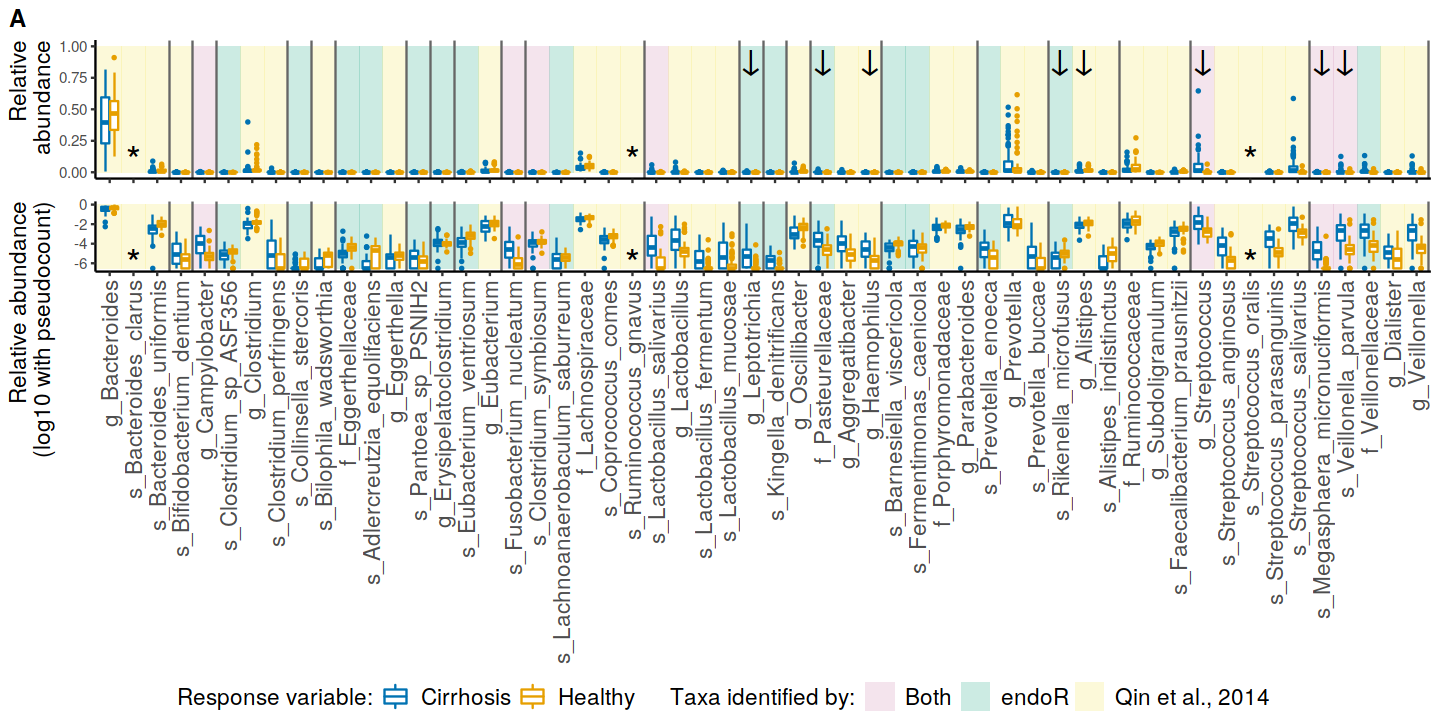

In [25]:
options(repr.plot.width=12, repr.plot.height=6)
ra_plots

## Individual

In [26]:
X_tmp <- X
X_tmp[X == 0] <- mini

In [27]:
mm_plot <- ggplot(X_tmp, aes(x = target, y = log10(s_Megasphaera_micronuciformis)))+
geom_quasirandom(aes(color = target), alpha = 0.7, size = 3, width = 0.3)+
geom_boxplot(outlier.colour = NA, fill = NA)+
theme_classic()+
#ylim(limi)+
scale_color_manual(values = c("#0072B2","#E69F00"))+
labs(y = 'Megasphaera\nmicronuciformis', title = '1st highest endoR FI')+
theme(axis.title.x = element_blank(), axis.text = element_text(size = rel(1.2))
      , axis.title.y = element_text(size = rel(1.2)), legend.position = 'none')

In [28]:
vp_plot <- ggplot(X_tmp, aes(x = target, y = log10(s_Veillonella_parvula)))+
geom_quasirandom(aes(color = target), alpha = 0.7, size = 3, width = 0.3)+
geom_boxplot(outlier.colour = NA, fill = NA)+
theme_classic()+
#ylim(limi)+
scale_color_manual(values = c("#0072B2","#E69F00"))+
labs(y = 'Veillonella parvula', title = '2nd highest endoR FI')+
theme(axis.title.x = element_blank(), axis.text = element_text(size = rel(1.2))
      , axis.title.y = element_text(size = rel(1.2)), legend.position = 'none')

In [29]:
strp_plot <- ggplot(X_tmp, aes(x = target, y = log10(g_Streptococcus)))+
geom_quasirandom(aes(color = target), alpha = 0.7, size = 3, width = 0.3)+
geom_boxplot(outlier.colour = NA, fill = NA)+
theme_classic()+
#ylim(limi)+
scale_color_manual(values = c("#0072B2","#E69F00"))+
labs(y = 'Streptococcus', title = '3rd highest endoR FI')+
theme(axis.title.x = element_blank(), axis.text = element_text(size = rel(1.2))
      , axis.title.y = element_text(size = rel(1.2)), legend.position = 'none')

In [30]:
lepto_plot <- ggplot(X_tmp, aes(x = target, y = log10(g_Leptotrichia)))+
geom_quasirandom(aes(color = target), alpha = 0.7, size = 3, width = 0.3)+
geom_boxplot(outlier.colour = NA, fill = NA)+
theme_classic()+
#ylim(limi)+
scale_color_manual(values = c("#0072B2","#E69F00"))+
labs(y = 'Leptotrichia', title = '4rth highest endoR FI')+
theme(axis.title.x = element_blank(), axis.text = element_text(size = rel(1.2))
      , axis.title.y = element_text(size = rel(1.2)), legend.position = 'none')

In [31]:
altp_plot <- ggplot(X_tmp, aes(x = target, y = log10(g_Alistipes)))+
geom_quasirandom(aes(color = target), alpha = 0.7, size = 3, width = 0.3)+
geom_boxplot(outlier.colour = NA, fill = NA)+
theme_classic()+
#ylim(limi)+
scale_color_manual(values = c("#0072B2","#E69F00"))+
labs(y = 'Alistipes', title = 'Identified by Qin et al., 2014')+
theme(axis.title.x = element_blank(), axis.text = element_text(size = rel(1.2))
      , axis.title.y = element_text(size = rel(1.2)), legend.position = 'none')

In [32]:
rikm_plot <- ggplot(X_tmp, aes(x = target, y = log10(s_Rikenella_microfusus)))+
geom_quasirandom(aes(color = target), alpha = 0.7, size = 3, width = 0.3)+
geom_boxplot(outlier.colour = NA, fill = NA)+
theme_classic()+
#ylim(limi)+
scale_color_manual(values = c("#0072B2","#E69F00"))+
labs(y = 'Rikenella microfusus', title = 'Identified with endoR')+
theme(axis.title.x = element_blank(), axis.text = element_text(size = rel(1.2))
      , axis.title.y = element_text(size = rel(1.2)), legend.position = 'none')

In [33]:
haemo_plot <- ggplot(X_tmp, aes(x = target, y = log10(g_Haemophilus)))+
geom_quasirandom(aes(color = target), alpha = 0.7, size = 3, width = 0.3)+
geom_boxplot(outlier.colour = NA, fill = NA)+
theme_classic()+
#ylim(limi)+
scale_color_manual(values = c("#0072B2","#E69F00"))+
labs(y = 'Haemophilus', title = 'Identified by Qin et al., 2014')+
theme(axis.title.x = element_blank(), axis.text = element_text(size = rel(1.2))
      , axis.title.y = element_text(size = rel(1.2)), legend.position = 'none')

In [34]:
pasteu_plot <- ggplot(X_tmp, aes(x = target, y = log10(f_Pasteurellaceae)))+
geom_quasirandom(aes(color = target), alpha = 0.7, size = 3, width = 0.3)+
geom_boxplot(outlier.colour = NA, fill = NA)+
theme_classic()+
#ylim(limi)+
scale_color_manual(values = c("#0072B2","#E69F00"))+
labs(y = 'Pasteurellaceae', title = 'Identified with endoR')+
theme(axis.title.x = element_blank(), axis.text = element_text(size = rel(1.2))
      , axis.title.y = element_text(size = rel(1.2)), legend.position = 'none')

In [35]:
ra_best3 <- ggarrange(mm_plot, vp_plot, strp_plot, lepto_plot
                      , altp_plot, rikm_plot, haemo_plot, pasteu_plot
                      , ncol = 4, nrow = 2, labels = LETTERS[2:10])

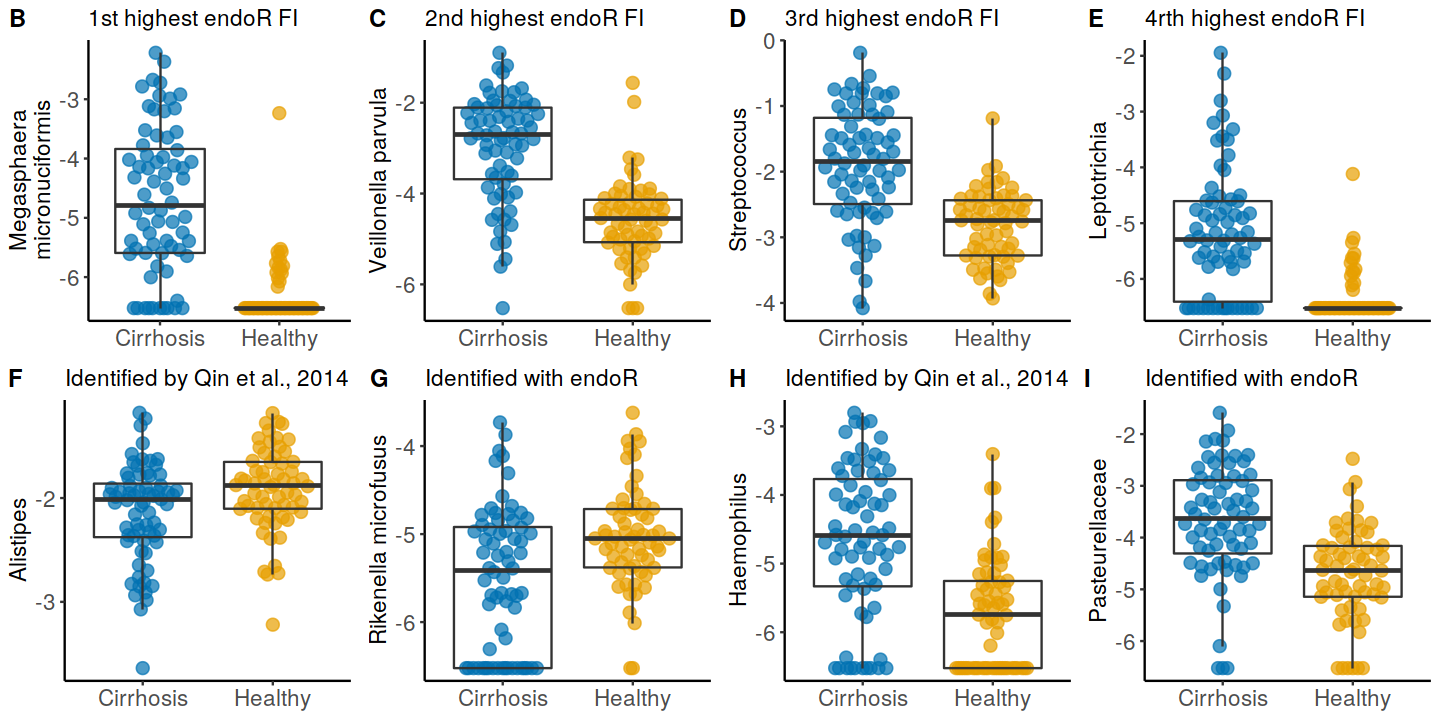

In [36]:
options(repr.plot.width=12, repr.plot.height=6)
ra_best3

## merge

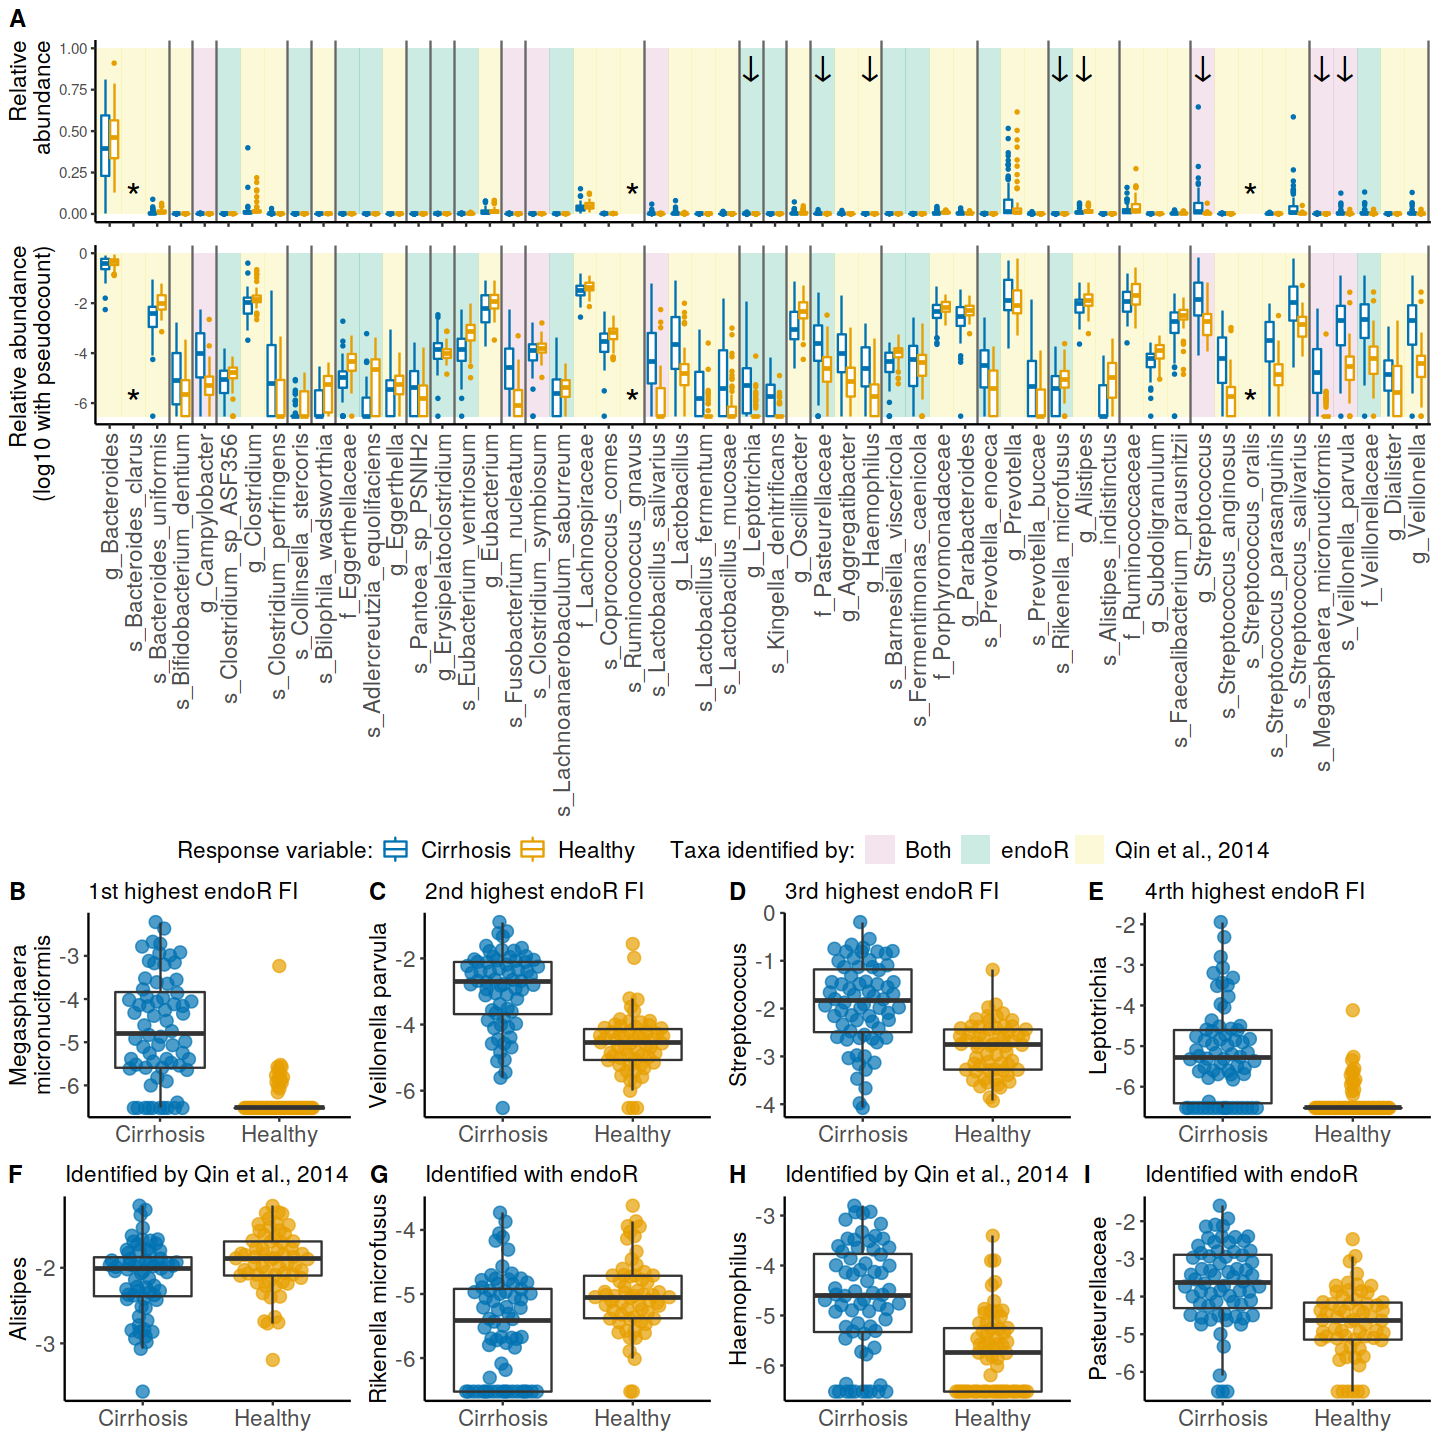

In [37]:
options(repr.plot.width=12, repr.plot.height=12)
all_plots <- ggarrange(ra_plots, ra_best3, ncol = 1, nrow = 2, heights = c(1, 0.65))
all_plots